In [1]:
## 施設名のエンコーディング
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
class FacilityDataset(Dataset):
    def __init__(self, facilities, targets=None):
        self.facilities = facilities
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = 128

    def __len__(self):
        return len(self.facilities)

    def __getitem__(self, idx):
        facility = str(self.facilities[idx])
        inputs = self.tokenizer.encode_plus(
            facility,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[idx], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }
            
train_df = pd.read_csv('train.csv')
facilities = train_df['FacilityName'].values
train_dataset = FacilityDataset(facilities, train_df['GHG_Direct_Emissions_14_in_metric_tons'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [3]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, ids, mask, token_type_ids):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # BERTのプーリングされた出力を取得
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
def rmsle_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))

In [ ]:
model = BertRegressor()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            ids = batch['ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = batch['mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
            token_type_ids = batch['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = batch['targets'].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(ids, mask, token_type_ids)
            loss = rmsle_loss(outputs, targets.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(model, train_loader, optimizer, num_epochs=5)

## 本題

In [97]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [98]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]
del train_df["FacilityName"], test_df["FacilityName"]

In [99]:
train_df.sample(5)

,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
2935,33.67057,-84.34614,1189 HENRICO RD,CONLEY,GA,30288,13063.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,55763.623522,68914.103895,43043.153597,16561.259113,47468.075881
1373,31.78220,-102.24720,14401 FM 3503,ODESSA,TX,79766,48461.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,11624.263268,46444.044514,52375.765415,37998.163528
2189,43.68610,-92.09170,701 INDUSTRIAL DR N,PRESTON,MN,55965,27045.0,325193,NaN,"Other,Suppliers of CO2",23766.826098,28389.309906,23651.606262,25429.795966,24296.052013,325709.100420,5335.633453,47921.763169,30438.151739
1008,37.36696,-121.94145,2600 DE LA CRUZ BLVD,SANTA CLARA,CA,950502618,6085.0,322130,NaN,Pulp and Paper,195241.802148,29653.192105,27193.800841,25439.399987,502415.818866,418593.406381,370215.366625,278465.961937,774837.261537
979,39.53429,-81.71607,201 RIGHTEOUS RIDGE RD,WATERFORD,OH,45786,39167.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,258195.832657,137531.600805,202020.891315,88212.090111,164365.410485


In [100]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns) | set(lat_lon_columns) | set(target_columns))))

## 前処理

### City

In [101]:
# # target encoding for city column
# City_median = train_df.groupby('City').GHG_Direct_Emissions_14_in_metric_tons.median()
# train_df['City_median'] = train_df['City'].map(City_median)
# test_df['City_median'] = test_df['City'].map(City_median)

# # if city is not present in test data then fill it with global median
# test_df['City_median'] = test_df['City_median'].fillna(train_df.GHG_Direct_Emissions_14_in_metric_tons.median())
# numerical_columns.append('City_median')

In [102]:
def Holdout_target_encoding(train, test, target, categorical_columns, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=15)
    for col in tqdm(categorical_columns):
        train[col + '_enc'] = np.nan
        for train_index, valid_index in kf.split(train):
            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            means = X_valid[col].map(X_train.groupby(col)[target].median())
            train.loc[valid_index, col + '_enc'] = means
        test[col + '_enc'] = test[col].map(train.groupby(col)[target].median())
        test[col + '_enc'].fillna(train[target].median(), inplace=True)
    return train, test
    
train_df, test_df = Holdout_target_encoding(train_df, test_df, 'GHG_Direct_Emissions_14_in_metric_tons', categorical_columns)
numerical_columns += [col + '_enc' for col in categorical_columns]

100%|██████████| 5/5 [00:00<00:00, 20.08it/s]


In [103]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique  = set(test_df[colname].unique())
    intersection = test_unique & train_unique
    return len(intersection)/test_df.shape[0]

In [104]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - LocationAddress has 1.036682615629984% values in train data
column - City has 34.05103668261563% values in train data
column - ZIP has 21.251993620414673% values in train data
column - State has 2.15311004784689% values in train data
column - IndustryType has 1.5151515151515151% values in train data


In [105]:
def create_features1(df):

    
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # Year-over-year growth rate
    df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [106]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                     'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']


train_df      = create_features2(train_df)
test_df       = create_features2(test_df)
new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 + new_features2

In [107]:
train = train_df[numerical_columns].values 
test  = test_df[numerical_columns].values 
target = train_df[target_columns].values

### Nan値うめ

In [108]:
for colname in numerical_columns:
    train_df[colname] = train_df[colname].fillna(train_df[colname].median())
    test_df[colname] = test_df[colname].fillna(train_df[colname].median())

## Optuna

In [109]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1),
        'verbose': -1,
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_params = study.best_params
optuna_params['random_state'] = 13
optuna_params['verbose'] = -1

    

[I 2024-11-06 08:45:51,316] A new study created in memory with name: no-name-001955ab-eec4-4258-9961-e3eaf4fb7ce9
[I 2024-11-06 08:45:52,275] Trial 0 finished with value: 1.223610029009886 and parameters: {'n_estimators': 131, 'learning_rate': 0.0009407552181031154, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.6125564279073297, 'colsample_bytree': 0.6620338270629577, 'reg_alpha': 0.011347131268179562, 'reg_lambda': 2.187907055033445}. Best is trial 0 with value: 1.223610029009886.
[I 2024-11-06 08:45:53,625] Trial 1 finished with value: 0.7645239964825337 and parameters: {'n_estimators': 175, 'learning_rate': 0.060534282269549544, 'num_leaves': 168, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.6140593337920235, 'colsample_bytree': 0.6810076265765841, 'reg_alpha': 0.0729477150012909, 'reg_lambda': 4.472479052519094}. Best is trial 1 with value: 0.7645239964825337.
[I 2024-11-06 08:45:59,189] Trial 2 finished with value: 0.7983662210422524 and par

KeyboardInterrupt: 

In [119]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-4, 1e1),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
        'scoring': 'neg_mean_squared_error',
        'verbose': 0,
    }
    
    model = HistGradientBoostingRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_hgbr_params = study.best_params
optuna_hgbr_params['random_state'] = 13
optuna_hgbr_params['verbose'] = -1


[I 2024-11-06 08:52:09,295] A new study created in memory with name: no-name-353229b5-ea1b-4d29-9e7e-48e6ef508e2e
[I 2024-11-06 08:52:23,315] Trial 0 finished with value: 0.7727797587626737 and parameters: {'learning_rate': 0.012713967209964282, 'max_iter': 537, 'max_leaf_nodes': 72, 'max_depth': 8, 'min_samples_leaf': 25, 'l2_regularization': 0.7416386742185481, 'max_bins': 173, 'early_stopping': False}. Best is trial 0 with value: 0.7727797587626737.
[I 2024-11-06 08:53:47,028] Trial 1 finished with value: 1.2382775641992168 and parameters: {'learning_rate': 0.00022200174074316398, 'max_iter': 426, 'max_leaf_nodes': 298, 'max_depth': 7, 'min_samples_leaf': 15, 'l2_regularization': 1.1528233876320448, 'max_bins': 147, 'early_stopping': True}. Best is trial 0 with value: 0.7727797587626737.
[I 2024-11-06 08:55:38,361] Trial 2 finished with value: 1.1800378413553334 and parameters: {'learning_rate': 0.0003090666203291097, 'max_iter': 579, 'max_leaf_nodes': 170, 'max_depth': 5, 'min_samp

In [120]:
# save params
joblib.dump(optuna_hgbr_params, 'optuna_hgbr_params.pkl')

['optuna_hgbr_params.pkl']

In [ ]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid             = train[train_index], train[valid_index]
        y_train, y_valid             = target[train_index], target[valid_index]

        params                       = optuna_params
        model1                       = LGBMRegressor(**params)

        params                       = optuna_hgbr_params
        model2                       = HistGradientBoostingRegressor(**params)

        _                             = model1.fit(X_train,np.log1p(y_train))        
        valid_preds1                  = np.expm1(model1.predict(X_valid))
        rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        _                             = model2.fit(X_train,np.log1p(y_train))        
        valid_preds2                  = np.expm1(model2.predict(X_valid))
        rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")


        if rmsle1>=rmsle2:
            valid_preds = valid_preds2.copy()
            test_preds  = model2.predict(test)
        else:
            valid_preds = valid_preds1.copy()
            test_preds  = model1.predict(test)
        
    
        oof_predictions[valid_index]  = valid_preds
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,np.expm1(test_predictions), model1

In [116]:
oof_predictions,test_predictions, model = get_models_trained(train,test,target,15)

Fold 1 RMSLE for model1 = 0.7160627725398994
Fold 1 RMSLE for model2 = 0.7387470620697429
---------------

Fold 2 RMSLE for model1 = 0.6840353351131382
Fold 2 RMSLE for model2 = 0.6867808752240662
---------------

Fold 3 RMSLE for model1 = 0.8165402827429498
Fold 3 RMSLE for model2 = 0.8152195044016761
---------------

Fold 4 RMSLE for model1 = 0.7349961214003033
Fold 4 RMSLE for model2 = 0.7452135782540383
---------------

Fold 5 RMSLE for model1 = 0.850962074695778
Fold 5 RMSLE for model2 = 0.8672362878630473
---------------

Fold 6 RMSLE for model1 = 0.8022120686626009
Fold 6 RMSLE for model2 = 0.8242315295821541
---------------

Fold 7 RMSLE for model1 = 0.7709528268968182
Fold 7 RMSLE for model2 = 0.7801330456309187
---------------

Fold 8 RMSLE for model1 = 0.6812280490704045
Fold 8 RMSLE for model2 = 0.6935792890759986
---------------

Fold 9 RMSLE for model1 = 0.7632909501835805
Fold 9 RMSLE for model2 = 0.7798425153519225
---------------

Fold 10 RMSLE for model1 = 0.784566788

## 後分析

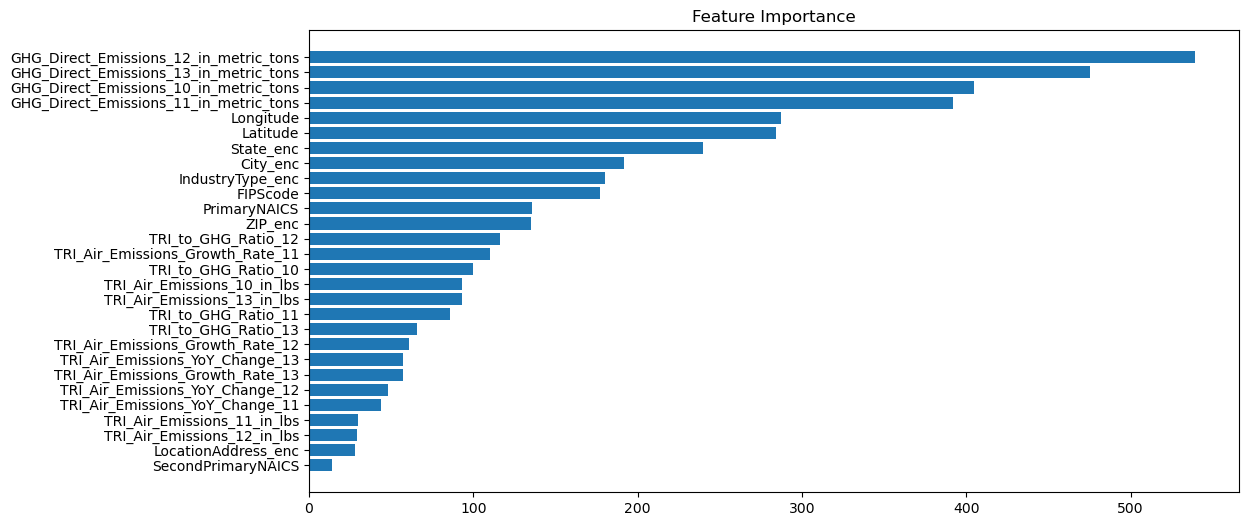

In [112]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, numerical_columns)

In [113]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )